# Volume Scattering of Neutrinos at Summit Station

*Problem outlined by Dr. Dave Z. Besson, Physics Professor at the University of Kansas. Produced as part of work in the Summer 2023 KU Physics and Astronomy REU Program.*

-----
A receiver placed in ice will receive a signal from a transmitter 100 meters away. The transmitter's signal will fall off as 1/r. If the source has some initial amplitude $A_0$, then the amplitude of the signal without any attenuation at a point S at distance $r_1$ will be $\frac{A_0}{r_1}$. Then, say that that point, the signal is scattered to the receiver an additional distance $r_2$ away. Following the above logic, the final signal received is then $A = \frac{A_0}{r_1r_2}$. However, there is one additional factor which has been neglected here, which is the phase. The amplitude of a wave at a point a distance $r$ from the receiver will be $\frac{A_0}{r}cos(kr)$, where $k$ is the wavenumber $\frac{2\pi}{\lambda}$. Here, the wavelength is chosen to be 1 meter.

To find the total amplitude of the signal at the receiver, then one should integrate over the volume from the transmitter to the receiver plus a buffer zone of 10 meters. So, integrate over a sphere centered between the transmitter and receiver with a diameter of 120 meters. In this scenario, the differential volume element must be appreciably smaller than the wavelength so that the phase is the same within the region.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
### Set up all of the initial conditions ###

n_ice = 1.78 # index of refraction in ice
c = 0.3/n_ice # speed of light in ice in m/ns
wavelength = 1 # wavelength of radio wave
k = 2*np.pi/wavelength # wavenumber of wave
A_0 = 1 # initial amplitude (arbitrary)

d = 100 # distance between receiver and transmitter
ti = 593.3 # initial time in ns
tf = 800 # final time in ns
dt = 0.1 # time step increment in ns
t = np.arange(ti, tf, dt) # time array

diameter = d + 20 # diameter of sphere to integrate over
radius = diameter/2 # radius of integration
dl = 0.1 # differential length element in m
dz = 0.1 # differential z-axis element in m

transmitter_l = 50 # x-axis position of transmitter
receiver_l = -50 # x-axis position of receiver
transmitter_z = 0 # z-axis position of transmitter
receiver_z = 0 # z-axis position of receiver

In [3]:
@njit # numba compiles code to C at runtime, producing a huge speedup
def amplitude(t_i, dt, radius, dl, dz, transmitter_l, receiver_l, transmitter_z, receiver_z):
    '''
    A function to determine the total 'weighted amplitude' that reaches the receiver between a time
    t_i and a short later time t_i+dt. This amplitude is calculated by integrating the absorbed and
    re-emitted signal from ice particles in a sphere around the apparatuses. Specifically, the
    volume integrated over is a sphere centered between the transmitter and receiver with a radius
    of 60 meters, which extends 10 meters beyond the devices. From here, the symmetry of the problem
    allows us to reduce this volume integral to one over a semicircle, where we multiply the final
    result by a factor of 2pi. This is because we initially integrate over annuli with a radial
    thickness dz and width dl. However, because the total path length for beams interacting with
    particles in these annuli is constant, integrating over the azimuthal angle only introduces
    a multiplicative factor of 2pi.
    
    
    PARAMETERS
    ----------
    t_i: `float`
        Initial time in ns
    dt: `float`
        Time increment in ns
    radius: `float`
        Radius of semicircle used in volume integration (R-T separation + 20)/2 in meters
    dl: `float`
        Differential x-axis length
    dz: `float`
        Differential z-axis length
    transmitter_l: `float`
        x-axis position of transmitter 
    receiver_l: `float`
        x-axis position of receiver 
    transmitter_z: `float`
        z-axis position of transmitter 
    transmitter_z: `float`
        z-axis position of receiver 
    
    OUTPUTS
    -------
    A: `float`
        Total integrated amplitude received between t_i and t_i+dt
    '''
    
    A = 0 # initialize received amplitude
    # create a grid of l-z pairs to integrate over
    l_array = np.arange(-1*radius, radius, dl) # all l values
    z_array = np.arange(0, radius, dz) # all z values
    for l in l_array:
        for z in z_array:
            if np.sqrt(l**2 + z**2) > radius: # ignore any points outside of semicircle
                continue
            
            l1 = l - transmitter_l # x-distance between intermediate point and transmitter
            z1 = z - transmitter_z # z-distance between intermediate point and transmitter
            r1 = np.sqrt(l1**2 + z1**2) # path length to intermediate point

            l2 = l - receiver_l # x-distance between intermediate point and receiver
            z2 = z - receiver_z # z-distance between intermediate point and receiver
            r2 = np.sqrt(l2**2 + z2**2) # path length to receiver from intermediate point
            
            transmission_time = (r1+r2)/c # calculate the total light travel time
            
            # only add the contribution from this point if the time it takes for the signal 
            # to travel through this path is within the time window in consideration
            if t_i < transmission_time < t_i + dt:
                # the amplitude contribution from this differential element is that from
                # an annulus centered at l. From the project description, this is A_0/r1r2.
                # I include a slight "padding" factor in the denominator to account for r1
                # or r2 equal to 0. Then the factor of 2pi accounts for the azimuthal
                # integral, and the cos term accounts for the phase. Appropriate
                # differential elements are included, as described in the description.
                dA = 2*np.pi * A_0 / (r1*r2 + 1e-5) * np.cos(k*(r1+r2)) * dl * dz
                A += dA
    return A

In [4]:
args = (dt, radius, dl, dz, transmitter_l, receiver_l, transmitter_z, receiver_z) # parameters
amp = [amplitude(t_i, *args) for t_i in t] # calculate the received amplitude at a variety of times

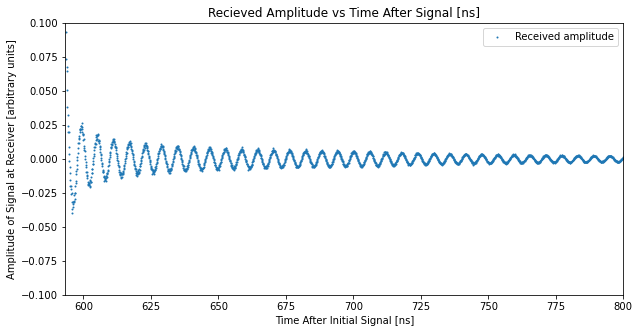

In [5]:
plt.figure(figsize=(10, 5))
plt.scatter(t, amp, s=1, label='Received amplitude')
plt.xlim(ti, tf)
plt.ylim(-0.1, 0.1)
plt.title('Recieved Amplitude vs Time After Signal [ns]')
plt.xlabel('Time After Initial Signal [ns]')
plt.ylabel('Amplitude of Signal at Receiver [arbitrary units]')
plt.legend();